In [169]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

In [170]:
# read dataset
raw_df = pd.read_csv('../input/multilingual-spam-data/data-en-hi-de-fr.csv')
raw_df.head()

,labels,text,text_hi,text_de,text_fr
0,ham,"Go until jurong point, crazy.. Available only ...","Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान वि...","Gehen Sie bis jurong Punkt, verrückt.. Verfügb...","Allez jusqu'à Jurong point, fou.. Disponible s..."
1,ham,Ok lar... Joking wif u oni...,ओके लामर.... if if uue पर.,Ok Lar... joking wif u oni...,J'ai fait une blague sur le wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प...,Freier Eintritt in 2 a wkly comp zum Gewinn FA...,Entrée libre dans 2 a wkly comp pour gagner FA...
3,ham,U dun say so early hor... U c already then say...,Uden इतना जल्दी कहते हैं... तो पहले से ही यूसी...,U dun sagen so früh... U c schon dann sagen...,U dun dit si tôt hor... U c déjà dire alors...
4,ham,"Nah I don't think he goes to usf, he lives aro...","नहीं, मुझे नहीं लगता कि वह हमारे लिए चला जाता ...","Nein, ich glaube nicht, dass er zu unsf geht, ...","Non, je ne pense pas qu'il va à usf, il vit da..."


In [171]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   labels   5572 non-null   object
 1   text     5572 non-null   object
 2   text_hi  5572 non-null   object
 3   text_de  5572 non-null   object
 4   text_fr  5572 non-null   object
dtypes: object(5)
memory usage: 217.8+ KB


In [172]:
raw_df["email"] = raw_df["text_fr"]
raw_df["label"] = raw_df["labels"]
raw_df.drop(columns = ["labels", 'text', 'text_hi', 'text_de', "text_fr"], inplace =True)
raw_df.head()

,email,label
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",ham
1,J'ai fait une blague sur le wif u oni...,ham
2,Entrée libre dans 2 a wkly comp pour gagner FA...,spam
3,U dun dit si tôt hor... U c déjà dire alors...,ham
4,"Non, je ne pense pas qu'il va à usf, il vit da...",ham


In [173]:
raw_df['label'] = raw_df['label'].map({'ham':'0',
                             'spam':'1',
                              },
                             na_action=None)

In [174]:
raw_df['label'] = raw_df['label'].astype("float")
raw_df.head()

,email,label
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",0.0
1,J'ai fait une blague sur le wif u oni...,0.0
2,Entrée libre dans 2 a wkly comp pour gagner FA...,1.0
3,U dun dit si tôt hor... U c déjà dire alors...,0.0
4,"Non, je ne pense pas qu'il va à usf, il vit da...",0.0


##### raw_df.info()

In [175]:
raw_df[raw_df.isnull().any(axis=1)]

,email,label


In [176]:
raw_df.dropna(inplace=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   email   5572 non-null   object 
 1   label   5572 non-null   float64
dtypes: float64(1), object(1)
memory usage: 130.6+ KB


In [177]:
raw_df["label"].value_counts()

0.0    4825
1.0     747
Name: label, dtype: int64

In [178]:
raw_df["label"].value_counts()

0.0    4825
1.0     747
Name: label, dtype: int64

In [179]:
x = raw_df['email']
y = raw_df['label']

In [180]:
# Split the datasets into a training set and a test set.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
[el.shape for el in [x_train, x_test, y_train, y_test]]

[(4457,), (1115,), (4457,), (1115,)]

In [181]:
# check balance of classes in train and test sets
pd.concat(
    [
        y.value_counts(normalize=True).rename(name)*100 
        for y, name in zip([y_train, y_test], ['y_train', 'y_test'])
    ], 
    axis=1
)

,y_train,y_test
0.0,86.582903,86.636771
1.0,13.417097,13.363229


In [182]:
# Write a data preparation pipeline to convert each email into a feature vector.
cv = CountVectorizer()
cv_x_train = cv.fit_transform(x_train).toarray()
cv_x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [183]:
str(cv.vocabulary_)[:1000]

"{'répondre': 6826, 'gagner': 3578, '100': 261, 'hebdomadaire': 3885, 'où': 5658, 'se': 6989, 'tiendra': 7740, 'la': 4509, 'coupe': 2296, 'du': 2766, 'monde': 5151, 'de': 2479, 'fifa': 3350, '2006': 369, 'envoyer': 3086, 'stop': 7412, '87239': 698, 'pour': 6096, 'terminer': 7658, 'le': 4567, 'service': 7065, 'alors': 975, 'ne': 5322, 'rentre': 6593, 'pas': 5767, 'maison': 4842, 'je': 4334, 'mange': 4870, 'des': 2532, 'nachos': 5287, 'pourquoi': 6099, 'guoyang': 3802, 'lui': 4752, 'il': 4069, 'dit': 2649, 'tu': 7947, 'as': 1191, 'hey': 3915, 'sathya': 6939, 'jusqu': 4424, 'maintenant': 4838, 'on': 5559, 'voit': 8251, 'même': 5280, 'une': 8016, 'seule': 7071, 'fois': 3420, 'comment': 2102, 'puis': 6315, 'voir': 8247, 'situation': 7165, 'orange': 5590, 'vous': 8286, 'apporte': 1107, 'sonneries': 7256, 'tous': 7847, 'les': 4590, 'temps': 7639, 'chart': 1875, 'heroes': 3907, 'avec': 1315, 'un': 8012, 'succès': 7446, 'gratuit': 3755, 'chaque': 1863, 'semaine': 7017, 'allez': 965, 'sur': 7509

In [184]:
raw_df.head()

,email,label
0,"Allez jusqu'à Jurong point, fou.. Disponible s...",0.0
1,J'ai fait une blague sur le wif u oni...,0.0
2,Entrée libre dans 2 a wkly comp pour gagner FA...,1.0
3,U dun dit si tôt hor... U c déjà dire alors...,0.0
4,"Non, je ne pense pas qu'il va à usf, il vit da...",0.0


In [185]:
raw_df.label.value_counts(normalize = True)

0.0    0.865937
1.0    0.134063
Name: label, dtype: float64

In [186]:
# functions for comparing default models
plt.rcParams["figure.figsize"] = (15, 4)

def calc_model_performance(model, x, y):
    y_pred = cross_val_predict(model, x, y, cv=4)
    
    metrics_dict = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1': f1_score(y, y_pred)
    }
    metrics_df = pd.DataFrame(metrics_dict, index=[str(model)])
    
    return metrics_df, y_pred

def plot_text_metrics(model, metrics_df):
    model_name = str(model)
    text = f"""
        {model_name}

        Accuracy = {metrics_df.loc[model_name, 'Accuracy']}
        Precision = {metrics_df.loc[model_name, 'Precision']}
        Recall = {metrics_df.loc[model_name, 'Recall']}
        F1 = {metrics_df.loc[model_name, 'F1']}
        """
    plt.annotate(text, xy=(0.5, 1), xytext=(2.5, -.2), size='xx-large', ha='center')

def plot_precision_recall_vs_threshold(model, x, y, score_method):
    y_scores = cross_val_predict(model, x, y, cv=4, method=score_method)
    if score_method == 'predict_proba':
        y_scores = y_scores[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
    
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.title('PR curve')
    plt.xlabel('Threshold')
    plt.legend(loc='center right')
    
def plot_conf_matrix(y, y_pred):
    sns.heatmap(confusion_matrix(y, y_pred), annot=True, fmt='d').set_title('Confussion Matrix')
    
def plot_model_performance(model, x, y, score_method):
    global all_metrics_df # df for storing default models scores
    
    metrics_df, y_pred = calc_model_performance(model, x, y)
    
    plt.subplot(121)
    plot_text_metrics(model, metrics_df)
    plot_conf_matrix(y, y_pred)
    
    plt.subplot(122)
    plot_precision_recall_vs_threshold(model, x, y, score_method)
    
    all_metrics_df = pd.concat([all_metrics_df, metrics_df])

In [187]:
# df for storing default models scores
all_metrics_df = pd.DataFrame(columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
all_metrics_df

,Accuracy,Precision,Recall,F1


In [188]:
# plot_model_performance(SGDClassifier(random_state=42), cv_x_train, y_train, "decision_function")

In [189]:
# plot_model_performance(DecisionTreeClassifier(random_state=42), cv_x_train, y_train, 'predict_proba')

In [190]:
# plot_model_performance(RandomForestClassifier(random_state=42), cv_x_train, y_train, 'predict_proba')

In [191]:
# plot_model_performance(KNeighborsClassifier(), cv_x_train, y_train, 'predict_proba')

In [192]:
all_metrics_df.sort_values('F1', ascending=False)

,Accuracy,Precision,Recall,F1


Default RandomForestClassifier showed the best results. Also, it is better to be correct about predicted spam messages rather than detect more spam messages, because this way, we minimize the risk of classifying important messages into the spam section. So precision has a higher priority than recall. As we can see, RandomForestClassifier was wrong with only about 2 predicted spam messages and recall is also high enough. Let's build a pipeline with RandomForestClassifier and try different hyperparameters.

In [193]:
pipe = Pipeline([
    ('data-prep', CountVectorizer()),
    ('rfr', RandomForestClassifier(random_state=42))
])

In [194]:
from sklearn import set_config

set_config(display='diagram')
# with display='diagram', simply use display() to see the diagram
display(pipe)
# if desired, set display back to the default
set_config(display='text')

Pipeline(steps=[('data-prep', CountVectorizer()),
                ('rfr', RandomForestClassifier(random_state=42))])

In [195]:
pipe.get_params()

{'memory': None,
 'steps': [('data-prep', CountVectorizer()),
  ('rfr', RandomForestClassifier(random_state=42))],
 'verbose': False,
 'data-prep': CountVectorizer(),
 'rfr': RandomForestClassifier(random_state=42),
 'data-prep__analyzer': 'word',
 'data-prep__binary': False,
 'data-prep__decode_error': 'strict',
 'data-prep__dtype': numpy.int64,
 'data-prep__encoding': 'utf-8',
 'data-prep__input': 'content',
 'data-prep__lowercase': True,
 'data-prep__max_df': 1.0,
 'data-prep__max_features': None,
 'data-prep__min_df': 1,
 'data-prep__ngram_range': (1, 1),
 'data-prep__preprocessor': None,
 'data-prep__stop_words': None,
 'data-prep__strip_accents': None,
 'data-prep__token_pattern': '(?u)\\b\\w\\w+\\b',
 'data-prep__tokenizer': None,
 'data-prep__vocabulary': None,
 'rfr__bootstrap': True,
 'rfr__ccp_alpha': 0.0,
 'rfr__class_weight': None,
 'rfr__criterion': 'gini',
 'rfr__max_depth': None,
 'rfr__max_features': 'auto',
 'rfr__max_leaf_nodes': None,
 'rfr__max_samples': None,
 'rf

In [196]:
param_grid = [
    {
        'data-prep__strip_accents': [None, 'ascii'],
        'data-prep__ngram_range': [(1, 1), (2, 2)],
        'rfr__n_estimators': [100], 
        'rfr__max_features': ['sqrt']
    }
]

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring=['f1', 'precision', 'recall', 'accuracy'],
    refit='f1',
    return_train_score=True
)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('data-prep', CountVectorizer()),
                                       ('rfr',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'data-prep__ngram_range': [(1, 1), (2, 2)],
                          'data-prep__strip_accents': [None, 'ascii'],
                          'rfr__max_features': ['sqrt'],
                          'rfr__n_estimators': [100]}],
             refit='f1', return_train_score=True,
             scoring=['f1', 'precision', 'recall', 'accuracy'])

In [197]:
grid_search.best_estimator_


Pipeline(steps=[('data-prep', CountVectorizer()),
                ('rfr',
                 RandomForestClassifier(max_features='sqrt', random_state=42))])

Default RandomForestClassifier is still the best. Let's test it on the test dataset.

In [198]:
best_pipe = grid_search.best_estimator_
y_pred = best_pipe.predict(x_test)
metrics_dict = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred)
}
pd.DataFrame(metrics_dict, index=[0])

,Accuracy,Precision,Recall,F1
0,0.98565,1.0,0.892617,0.943262


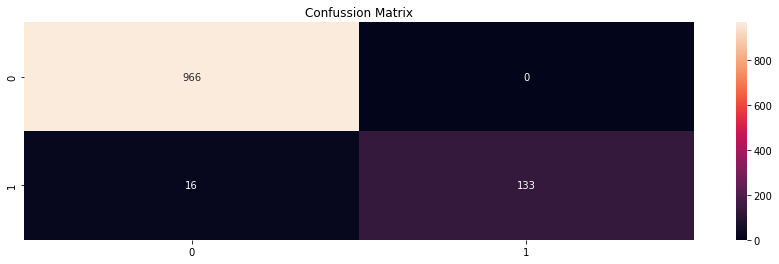

In [199]:
plot_conf_matrix(y_test, y_pred)

In [200]:
def test_spam_ham(text):
    data = {
        "email": text
    }
    
    df = pd.Series(data, index=[0])
    
    predict = best_pipe.predict(text) 
    
    if predict==0:
        
        print('not spam')
    else:
        print('spam')


In [201]:
message = ["More companies than ever are adopting AI. But there’s a big difference between pilot projects and production. And there are a lot of use cases and tools available. This free report will fill you in on where AI is growing, the tools developers are using to get projects into production, and more. Find out who’s using AI successfully—and how your company compares. Free"]

In [202]:
df = pd.Series(message, index=[0])

df

0    More companies than ever are adopting AI. But ...
dtype: object

In [203]:
test_spam_ham(df)

spam
